In [70]:
ZONE = "montenativo"
# Change this to False to re-download crops as part of this notebook.
CROPS_ALREADY_DOWNLOADED = False

In [71]:
# Load environment variables to download images.
# This defines the following environment variables:
# COPERNICUS_LOGIN, COPERNICUS_PASSWORD, AWS_SECRET_ACCESS_KEY, AWS_ACCESS_KEY_ID
import json
import os

with open("../env_vars.json", "r") as file:
    env_vars = json.load(file)
    for k, v in env_vars.items():
        os.environ[k] = v

In [109]:
%matplotlib inline

import sys
import os
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tsd
import geojson
import json
import folium
import rasterio, rasterio.mask
from PIL import Image, ImageDraw, ImageFont

sys.path.append("../forestry_yield_estimation")
import vistools, utils
from preprocessing import read_images, read_raw_points_data, get_catalog, get_aoi
from scraping import load_paysandu_weather

pd.options.mode.chained_assignment = None
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.4)

root = Path("..")
data_path = root / "data"
output_path = Path("../report/img")

In [ ]:
aoi = get_aoi(data_path, ZONE)
aoi_utm = get_aoi(data_path, ZONE, convert_to_utm=True)
aoi

In [74]:
fm = vistools.foliummap()
folium.GeoJson(aoi).add_to(fm)
fm.location = aoi["center"][::-1]

fm

In [75]:
south_catalog = get_catalog(data_path, "south", download_crops=False, start_date="2008-01-01", end_date="2021-04-10")
catalog = get_catalog(data_path, ZONE, download_crops=not CROPS_ALREADY_DOWNLOADED, start_date="2008-01-01", end_date="2021-04-10", ids_to_keep=south_catalog["id"])

Found 131 images
Found 131 images
Building 131 aws download urls... 

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

/home/nathra/build/tsd/tsd/utils.py:283: UserWarning: gdalwarp failed with error message: "ERROR 4: `/vsis3/sentinel-s1-l1c/GRD/2015/5/9/IW/DV/S1A_IW_GRDH_1SDV_20150509T090555_20150509T090620_005842_007849_0FFE/measurement/iw-vh.tiff' not recognized as a supported file format."
  warnings.warn('gdalwarp failed with error message: "{}"'.format(
/home/nathra/build/tsd/tsd/utils.py:283: UserWarning: gdalwarp failed with error message: "ERROR 4: `/vsis3/sentinel-s1-l1c/GRD/2016/3/4/IW/DV/S1A_IW_GRDH_1SDV_20160304T090555_20160304T090620_010217_00F168_BB6B/measurement/iw-vv.tiff' not recognized as a supported file format."
  warnings.warn('gdalwarp failed with error message: "{}"'.format(
/home/nathra/build/tsd/tsd/utils.py:283: UserWarning: gdalwarp failed with error message: "ERROR 4: `/vsis3/sentinel-s1-l1c/GRD/2016/3/4/IW/DV/S1A_IW_GRDH_1SDV_20160304T090555_20160304T090620_010217_00F168_BB6B/measurement/iw-vh.tiff' not recognized as a supported file format."
  warnings.warn('gdalwarp fai

In [76]:
raw_images, filenames, srcs = read_images(data_path, ZONE)
images = np.log(raw_images)
#images = raw_images
is_vv = np.array([f.endswith("vv") for f in filenames])

images_8bit = np.empty_like(images, dtype="uint8")
images_8bit[is_vv] = utils.simple_equalization_8bit(images[is_vv])
images_8bit[~is_vv] = utils.simple_equalization_8bit(images[~is_vv])

  0%|          | 0/232 [00:00<?, ?it/s]

In [77]:
weather = load_paysandu_weather(data_path)
weather.index = weather.index.map(str)
weather_dict = weather.T.to_dict()

In [124]:
from IPython.display import Image, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image


def display_image(img_index, vv=True):
    mask = (is_vv == vv)
    display(Image.fromarray(images_8bit[mask][img_index]))
    filename = filenames[mask][img_index]
    display(filename)
    w = weather_dict[filename[:10]]
    display(w)

applet = interactive(
    display_image,
    img_index=widgets.IntSlider(min=0, max=115, step=1, value=10, layout=widgets.Layout(width="100%")),
    vv=True
)
applet.layout.height = "550px"
applet

interactive(children=(IntSlider(value=10, description='img_index', layout=Layout(width='100%'), max=115), Chec…

# Mask extraction

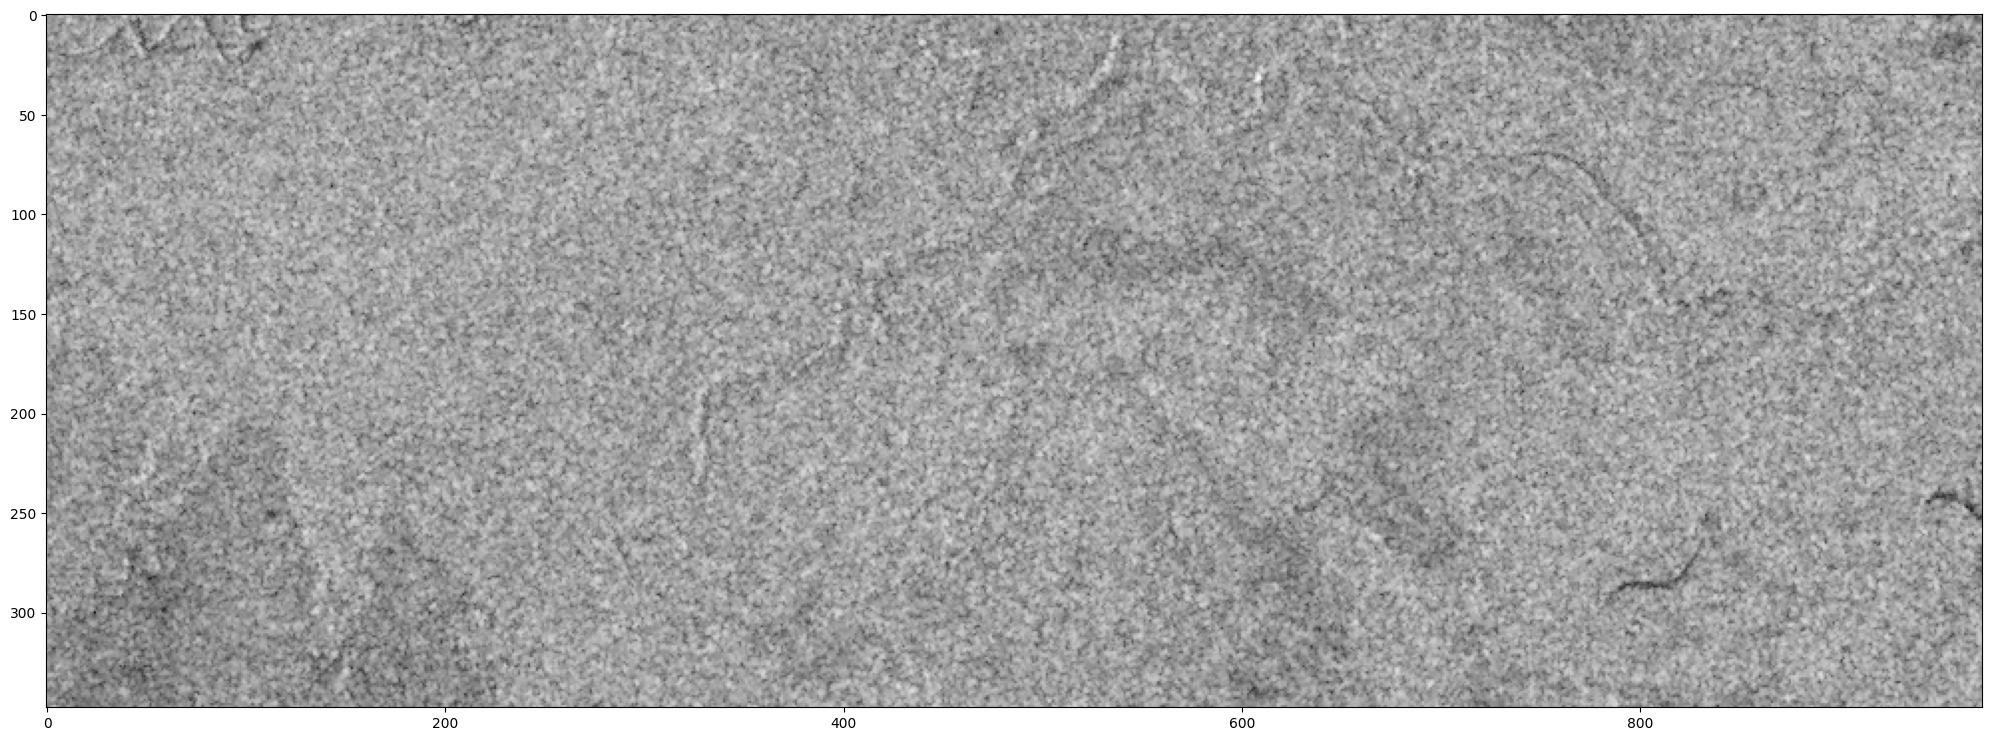

In [127]:
with plt.style.context("default"):
    ratio = images.shape[2] / images.shape[1]
    plt.subplots(figsize=(ratio*9, 9))
    plt.imshow(images[0], cmap="gray")
    plt.savefig(output_path/"images"/"montenativo_image.png")

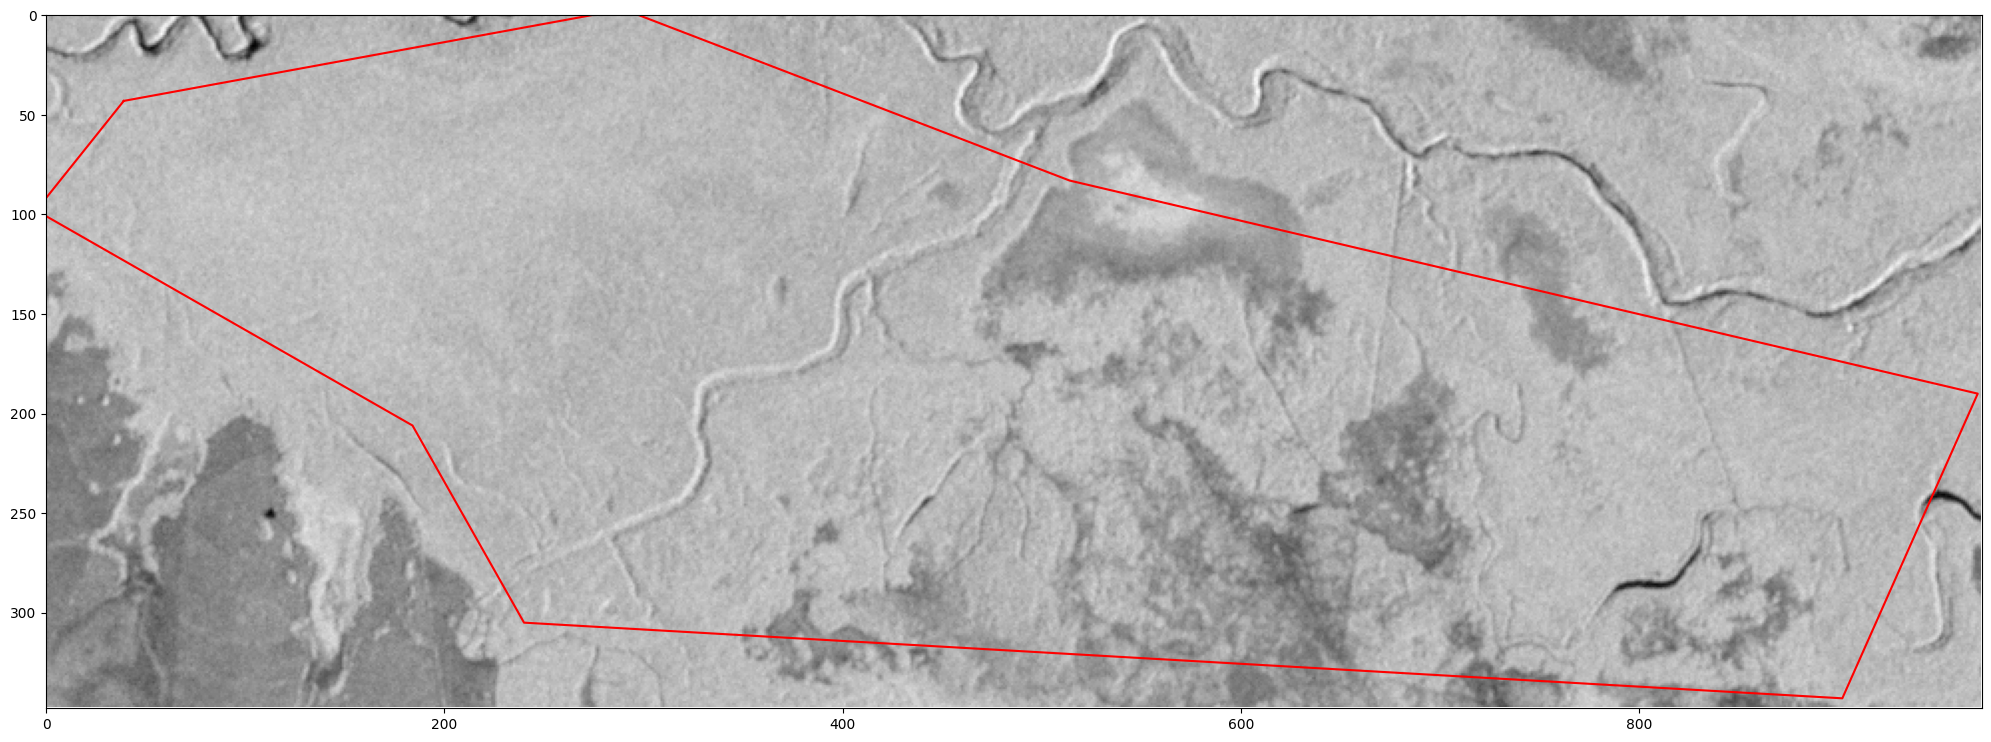

In [128]:
offset_correction = (-40, 20)
aoi_polygon = [
    [[easting + offset_correction[0], northing + offset_correction[1]] for easting, northing in sublist]
    for sublist in aoi_utm["coordinates"]
]

with plt.style.context("default"):
    plt.subplots(figsize=(ratio*9, 9))
    plt.imshow(np.median(images[:150], 0), cmap="gray")

    polygon = np.array([
        srcs[0].index(x, y)
        for x, y in aoi_polygon[0]
    ])
    plt.plot(polygon[:, 1], polygon[:, 0], c="red")
    plt.xlim(0, images.shape[2])
    plt.ylim(images.shape[1], 0)
plt.savefig(output_path/"polygons"/"montenativo_polygons.png")

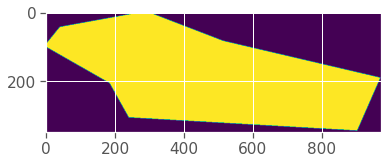

In [111]:
mask, _, _ = rasterio.mask.raster_geometry_mask(srcs[0], [geojson.Polygon(aoi_polygon)], invert=True)
plt.imshow(mask)

In [112]:
masks = np.repeat(mask[np.newaxis, ...], len(images), axis=0)

# Effect of weather

In [113]:
aggregated_backscatter = pd.DataFrame({
    "backscatter": np.median(images * masks, axis=(1, 2)),
    "polarisation": ["vv" if vv else "vh" for vv in is_vv],
    "date": [f[:10] for f in filenames],
})

df = aggregated_backscatter.merge(weather.reset_index(), on="date")

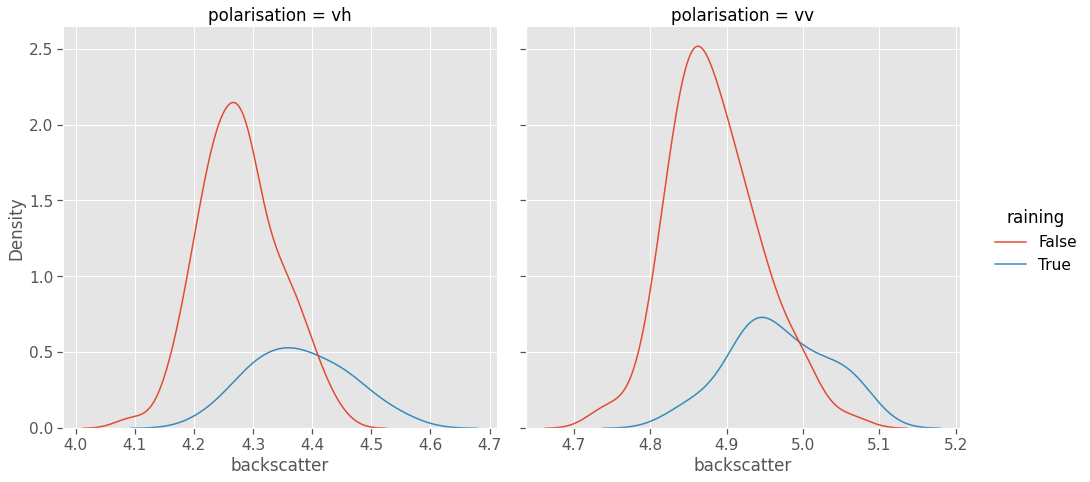

In [126]:
sns.displot(data=df.assign(raining=lambda df: df.rain>0), x="backscatter", hue="raining", col="polarisation", kind="kde", facet_kws=dict(sharex=False), height=7)
plt.savefig(output_path/"normalization"/"montenativo_rain.png")

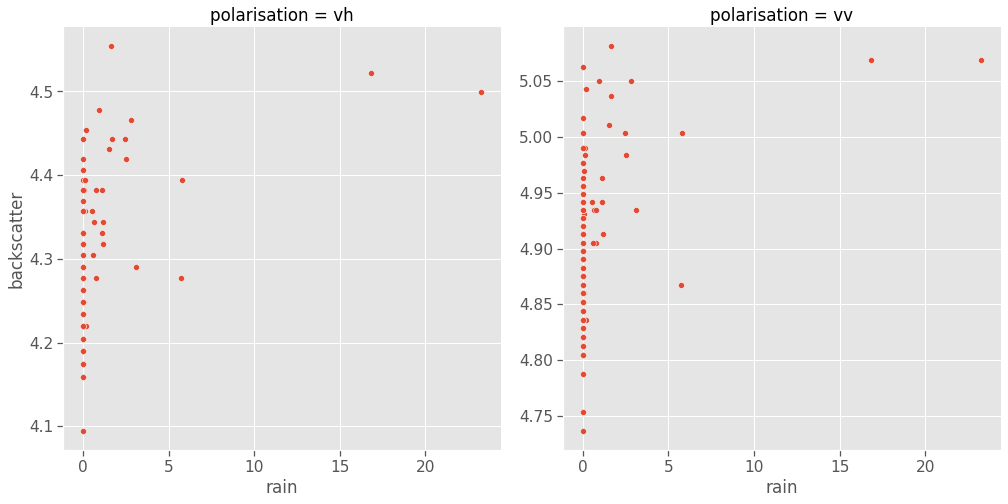

In [107]:
sns.relplot(data=df, x="rain", col="polarisation", y="backscatter", facet_kws=dict(sharey=False), height=7)

# Record mean intensities for normalisation

In [116]:
aggregated_backscatter = pd.DataFrame({
    "date": [f[:10] for f in filenames],
    "polarisation": ["vv" if vv else "vh" for vv in is_vv],
    "mean_backscatter": (images * masks).mean((1, 2)),
    "median_backscatter": np.median(images * masks, axis=(1, 2)),
})
aggregated_backscatter.to_csv(data_path/"montenativo.csv", index=False)
aggregated_backscatter

,date,polarisation,mean_backscatter,median_backscatter
0,2017-01-04,vh,2.787501,4.521789
1,2017-01-04,vv,3.109831,5.068904
2,2017-01-16,vh,2.742425,4.442651
3,2017-01-16,vv,3.082079,5.010635
4,2017-01-28,vh,2.622059,4.219508
...,...,...,...,...
227,2021-03-08,vv,2.995051,4.867535
228,2021-03-20,vh,2.631505,4.248495
229,2021-03-20,vv,2.993207,4.867535
230,2021-04-01,vh,2.616556,4.219508


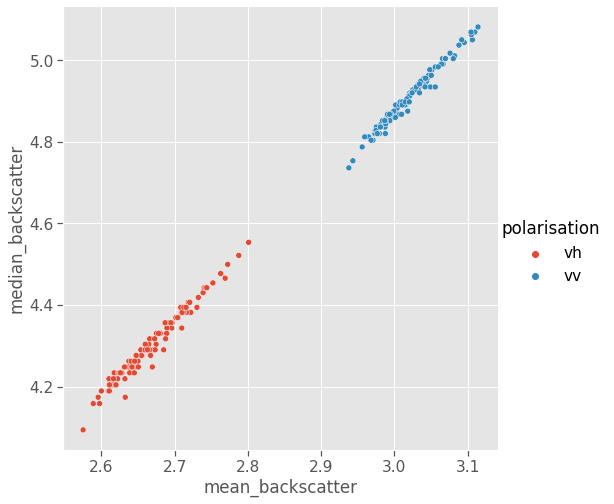

In [118]:
sns.relplot(data=aggregated_backscatter, x="mean_backscatter", y="median_backscatter", hue="polarisation", height=7)
plt.savefig(output_path/"results"/"montenativo_median_vs_mean.png")